# FCFS-Scheduling 

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term

# Solver Model
from src.models.heuristics import fcfs

# Extern
import pandas as pd

In [2]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp = init.production_orders(df_instance)
df_jssp

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
95,9,9,5,M09,76
96,9,9,6,M05,47
97,9,9,7,M03,52
98,9,9,8,M04,90


In [3]:
df_job_times = term.generate_arrivals(df_jssp, u_b_mmax = 0.9, var_type="Integer", random_seed=122)
df_job_times

,Job,Production_Plan_ID,Arrival
0,0,0,11
10,1,1,96
20,2,2,118
30,3,3,160
40,4,4,197
50,5,5,263
60,6,6,324
70,7,7,341
80,8,8,356
90,9,9,441


In [4]:
df_schedule = fcfs.schedule_with_arrivals(df_jssp, df_job_times)
df_schedule


Schedule-Informationen:
  Makespan: 1371


,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,0,0,11,M00,11,29,40
1,0,1,11,M01,40,78,118
2,0,2,11,M02,118,9,127
3,0,3,11,M03,127,36,163
4,0,4,11,M04,163,49,212
...,...,...,...,...,...,...,...
95,9,5,441,M09,1051,76,1127
96,9,6,441,M05,1127,47,1174
97,9,7,441,M03,1184,52,1236
98,9,8,441,M04,1236,90,1326


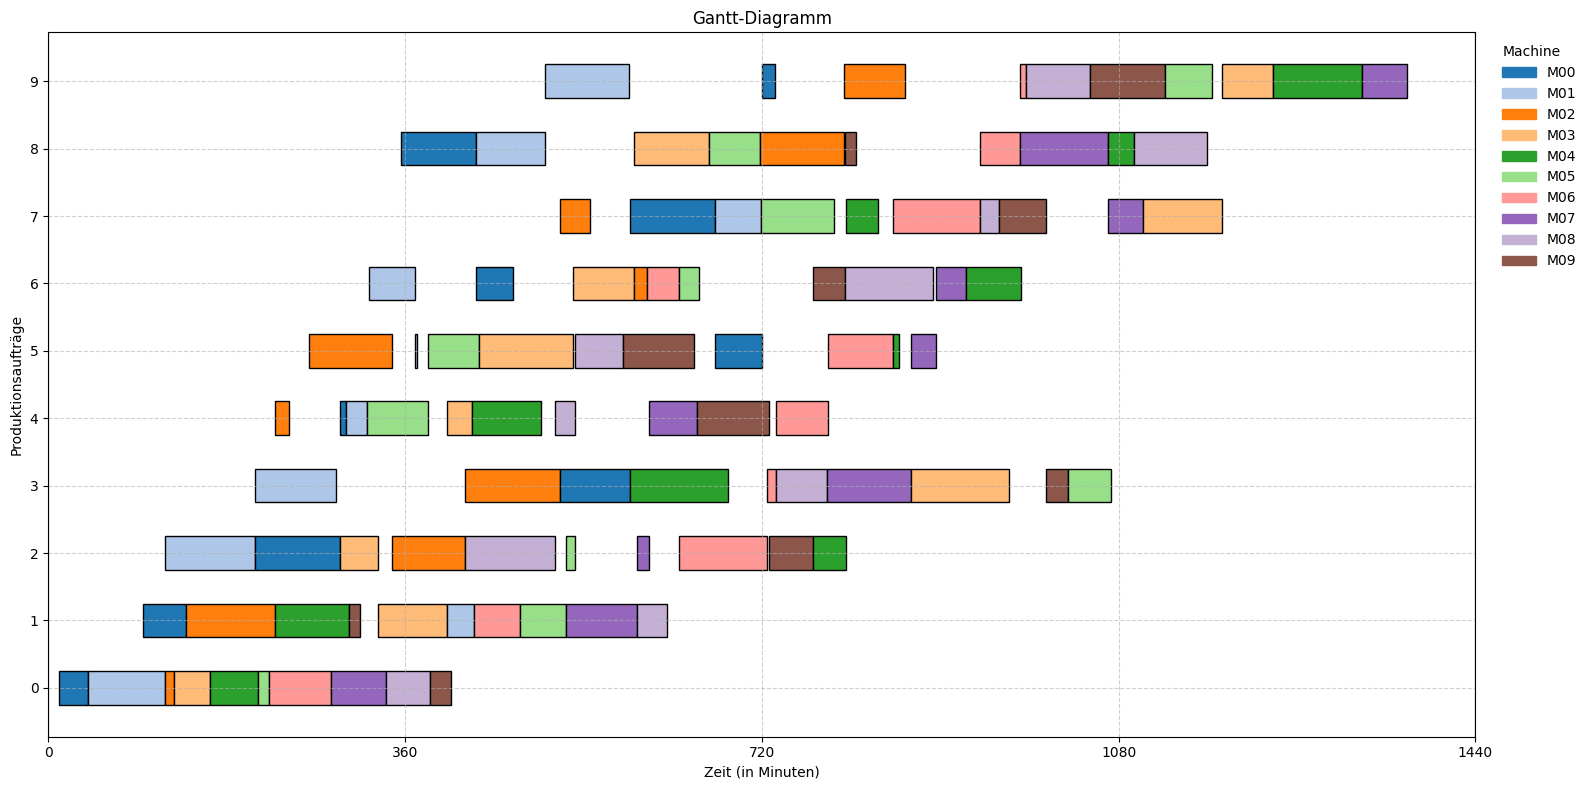

In [5]:
show.plot_gantt(df_schedule, perspective="Job")

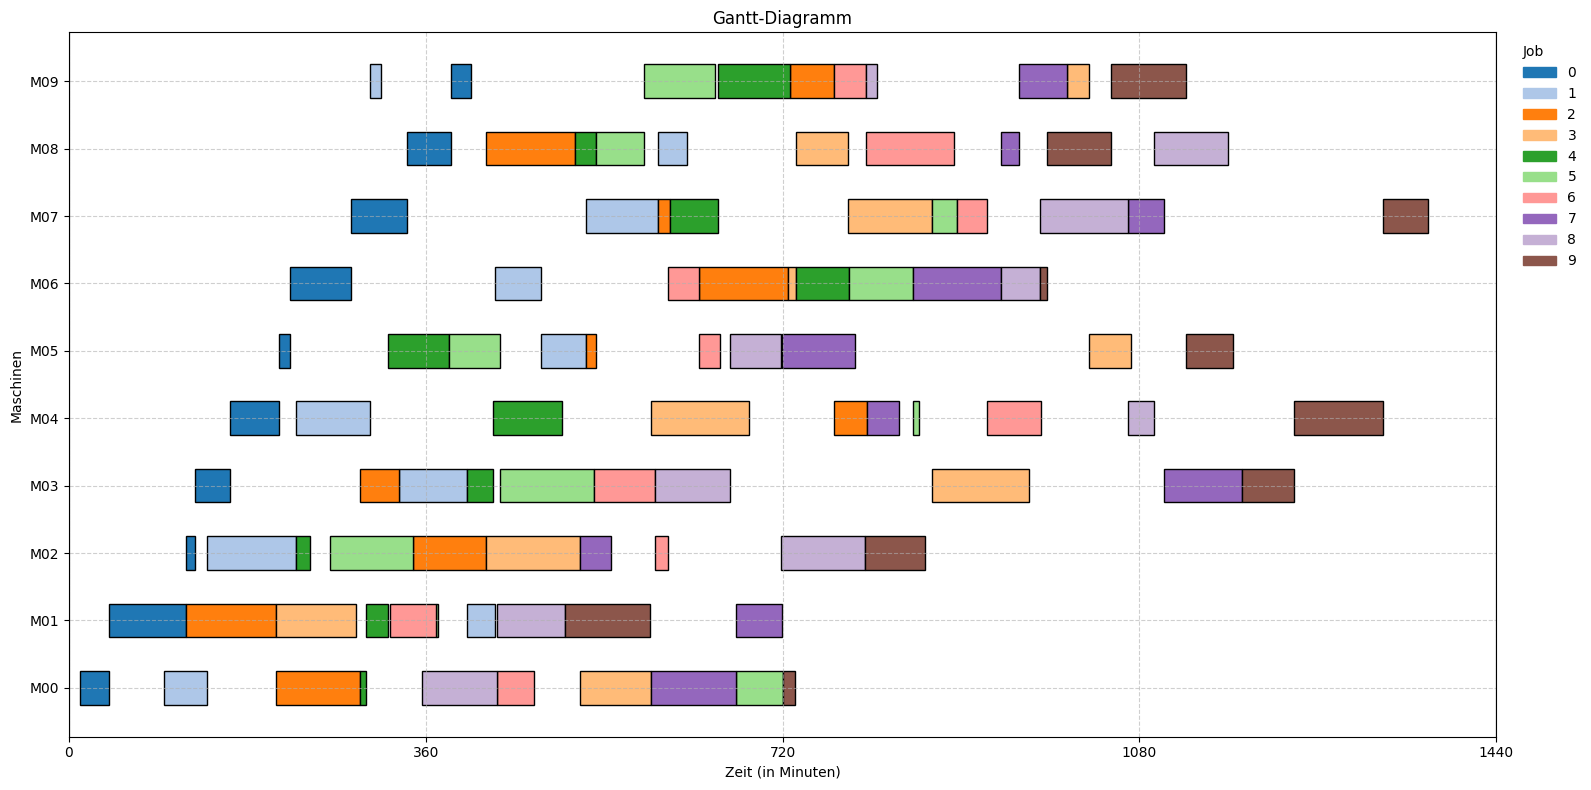

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)